# Overconfident Neural Networks

Reference: https://www.kaggle.com/code/jramkiss/overconfident-neural-networks/notebook

In [77]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, ConcatDataset, DataLoader

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [78]:
# Read in data from data folder
train_dir = '../data/afhq/train'
valid_dir = '../data/afhq/val'

# Show some images
from torchvision import datasets, transforms


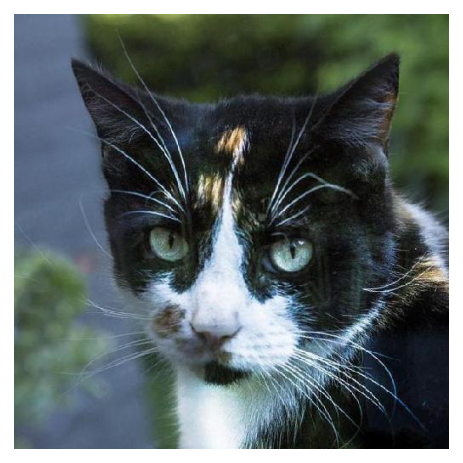

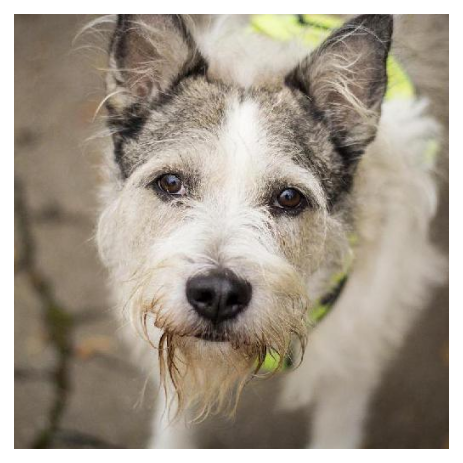

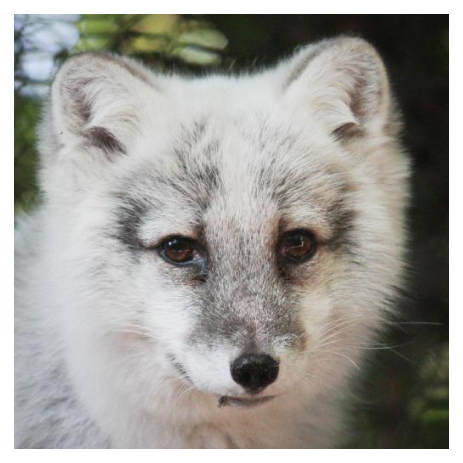

In [79]:
# Show first image in each folder: cat, dog, wild
def show_image(path):
    files = os.listdir(path)
    img = plt.imread(os.path.join(path, files[0]))
    plt.imshow(img)
    # Remove axis ticks
    plt.axis('off')
    plt.show()

show_image(os.path.join(train_dir, 'cat'))
show_image(os.path.join(train_dir, 'dog'))
show_image(os.path.join(train_dir, 'wild'))

In [80]:
# Show sizes of each image
from PIL import Image

def show_image_sizes(path):
    files = os.listdir(path)
    img = Image.open(os.path.join(path, files[0]))
    print(img.size)

show_image_sizes(os.path.join(train_dir, 'cat'))

(512, 512)


In [81]:
# Simple CNN with 3 convolutional layers, and 3 classes

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layers
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 3)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x) # Input is 3x512X512, output is 8x512x512
        x = nn.functional.relu(x)
        x = self.pool(x) # Output is 8x256x256
        x = self.conv2(x) # Input is 8x256x256, output is 16x256x256
        x = nn.functional.relu(x)
        x = self.pool(x) # Output is 16x128x128
        x = self.conv3(x) # Input is 16x128x128, output is 32x128x128
        x = nn.functional.relu(x)
        x = self.pool(x) # Output is 32x64x64
        x = self.conv4(x) # Input is 32x64x64, output is 32x64x64
        x = nn.functional.relu(x)
        x = self.pool(x) # Output is 32x32x32
        # Flatten
        x = x.view(-1, 32 * 32 * 32)
        # Linear layers
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # Softmax
        x = self.softmax(x)
        return x

In [82]:
cnn = SimpleCNN()
print(cnn)

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [83]:
cnn(torch.randn(1, 3, 512, 512))

tensor([[-1.0659, -1.0911, -1.1402]], grad_fn=<LogSoftmaxBackward0>)

In [84]:
# Number of 

In [106]:
batch_size = 32


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])



# Load the dataset using ImageFolder and apply the transformation
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)

# Select first 100 samples from cat classes
cat_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == 0]
cat_indices = cat_indices[:100]

# Select first 100 samples from dog classes
dog_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == 1]
dog_indices = dog_indices[:100]

# Select first 100 samples from wild classes
wild_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == 2]
wild_indices = wild_indices[:100]

# Concatenate the indices
indices = cat_indices + dog_indices + wild_indices

# Create a concatenated dataset
train_subset = Subset(train_dataset, indices)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True
)



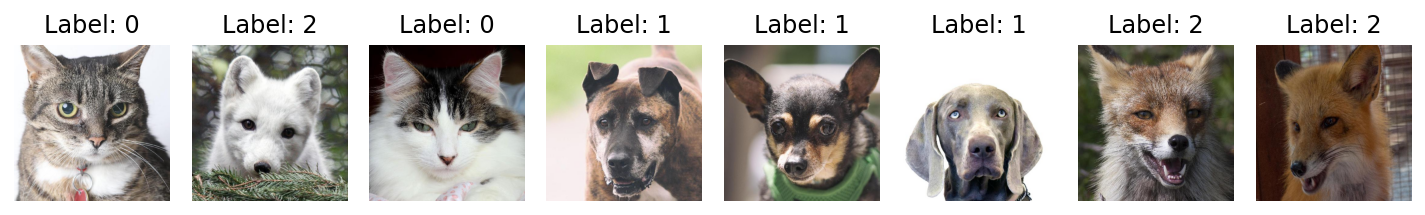

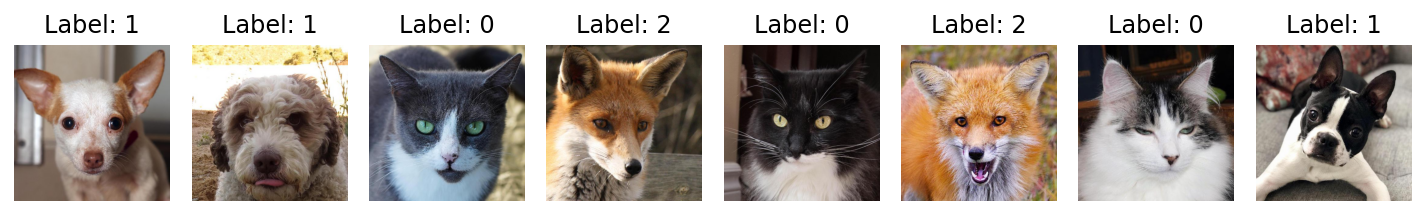

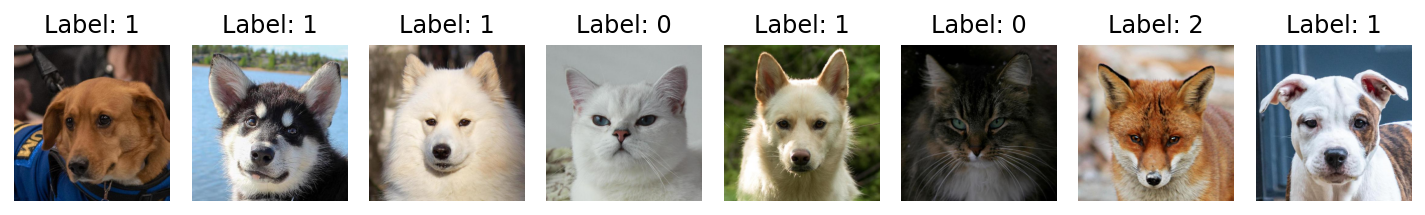

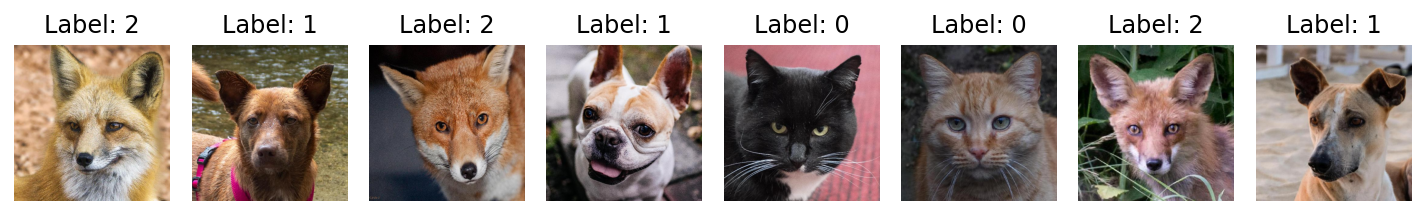

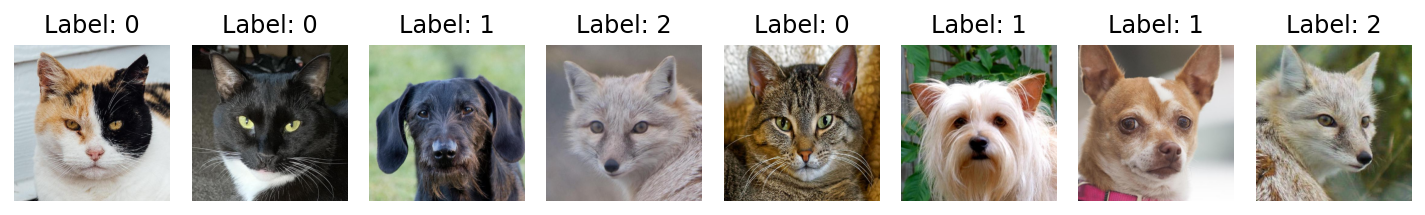

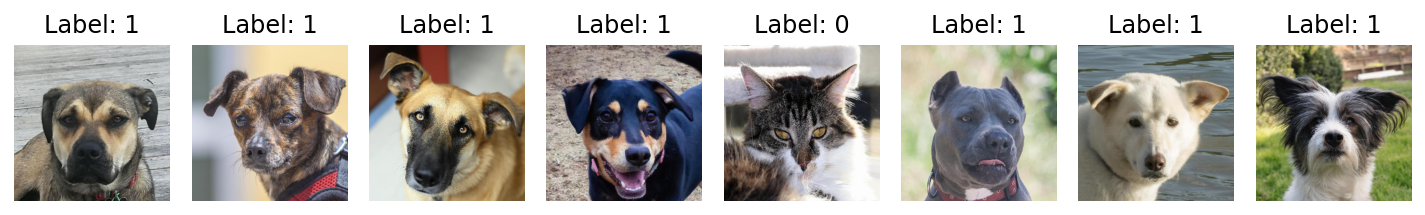

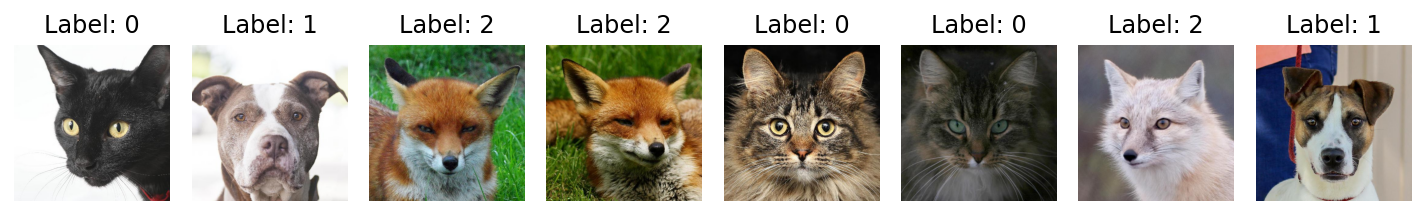

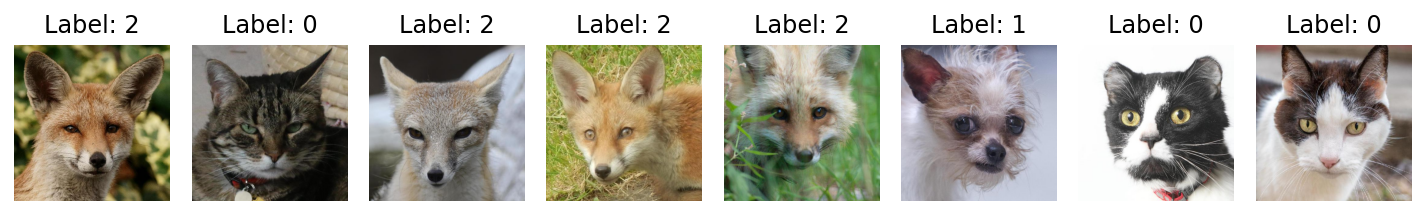

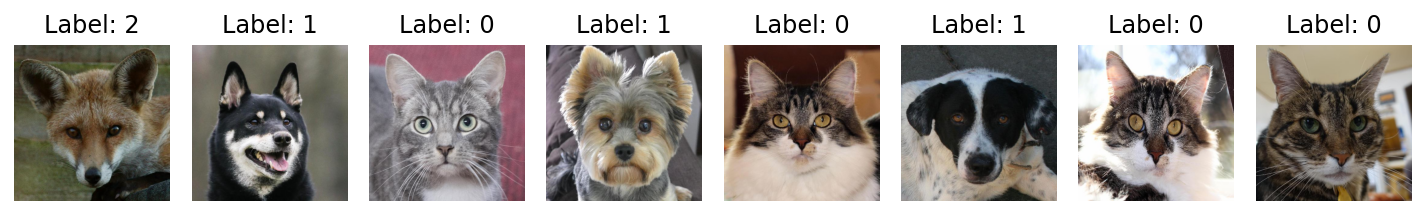

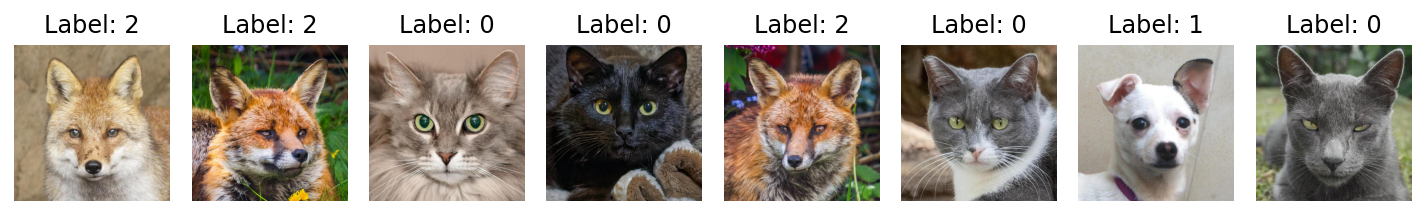

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate over the first batch of the train_loader
for images, labels in train_loader:
    # Convert images and labels to numpy arrays
    images = images.numpy()
    labels = labels.numpy()

    # Display the images and labels
    fig, axes = plt.subplots(figsize=(10, 5), ncols=8)
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    #break  # Break after displaying the first batch


In [109]:
# Train the model
from torch import optim

# Loss function
criterion = nn.NLLLoss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Number of epochs
epochs = 1

# Move model to GPU
cnn.cuda()

# Train the model
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    cnn.train()
    for data, target in train_loader:
        # Move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        output = cnn(data)
        # Calculate loss
        loss = criterion(output, target)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Update training loss
        print(loss.item() * data.size(0))
        train_loss += loss.item() * data.size(0)
    cnn.eval()
    
    # Average losses
    train_loss = train_loss / len(train_loader.dataset)
    

34.59089279174805
35.19190216064453
36.06556701660156
34.57152557373047


KeyboardInterrupt: 

In [110]:
# Predictions
cnn.eval()
images, labels = next(iter(train_loader ))

# Move tensors to GPU
images, labels = images.cuda(), labels.cuda()

# Get predictions
preds = cnn(images)



In [111]:
preds.argmax(dim=1)

tensor([1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 1, 1, 2, 2, 1, 2], device='cuda:0')